# Training

## Loss function
The loss function is the $L_2$ loss on the prediceted per-particle accelerations. The model parameters are optimizied over the loss using the Adam optimizer, using a minibatch size of 2.




In [1]:
#setup
%load_ext autoreload
%cd ".."

/workspace


In [2]:
!pip install livelossplot
!pip install tqdm

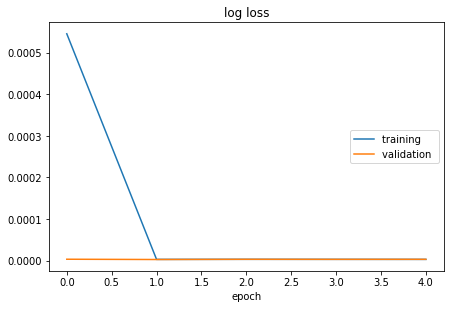

  0%|          | 3/6721 [00:00<04:23, 25.49it/s]

log loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


 51%|█████     | 438/858 [00:14<00:14, 29.20it/s]


KeyboardInterrupt: 

In [3]:
%autoreload 2
# Training loop
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from open_gns.models import EncodeProcessDecode
from open_gns.dataset import GNSDataset
from torch_geometric.data import DataLoader
from livelossplot import PlotLosses
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_train = GNSDataset('./notebooks')
dataset_val = GNSDataset('./notebooks', split='validation')
dataloaders = {
    'train': DataLoader(dataset_train, batch_size=2, shuffle=True),
    'validation': DataLoader(dataset_val, batch_size=2, shuffle=False)
}
input_size = dataset_train.num_node_features
model = EncodeProcessDecode(input_size).to(device)


optimizer = Adam(model.parameters(), lr=0.001)
mse = MSELoss()
liveloss = PlotLosses()

for epoch in range(10):
    logs = {}
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        running_loss = 0.0
        for i, data in enumerate(tqdm(dataloaders[phase])):
            data = data.to(device)
            y_pred = model(data.x, data.edge_index)
            loss = mse(y_pred, data.y)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss += loss.item()*data.num_graphs
        # Log epoch loss
        epoch_loss = running_loss/len(dataloaders[phase].dataset)
        label = 'log loss' if phase == 'train' else 'val_log loss'
        logs[label] = epoch_loss
        # Save checkpoint
        if phase == 'train':
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f'checkpoint_{epoch}_{epoch_loss}.pt')
    liveloss.update(logs)
    liveloss.send()
